# Importing Data

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns

In [23]:
data = r'D:\other studies\Quantium Case Comp 2024\QuantiumCaseComp2024\Risky Lending Data Set - revised.xlsx'

customers = pd.read_excel(data, sheet_name="Customers",header=5, usecols=range(1,8))
applications = pd.read_excel(data, sheet_name="Applications",header=5, usecols=range(1,10))
campaigns = pd.read_excel(data, sheet_name="Campaigns",header=5, usecols=range(1,8))
clawbacks= pd.read_excel(data, sheet_name="Clawbacks",header=5, usecols=range(1,5))

# DATES ARE YEAR-MONTH-DAY

# Descriptive analysis
## Revenue measurement
Measure revenue by getting summing loan amounts from applications sheet that do not have a clawback within 12 months (keep track of the account ID).
- Track clawbacks, check which ones closed the account within 1 year (difference between open date and close date should be less than 1 year or 365/366 days depending on leap or non-leap year).
- Remove the corresponding rows from the applications column by matching Account IDs.
- Sum the remaining loan values and multiply by 4% to get revenue for risky lending. Can do this by year also for comparison of revenue over the 3 years.
- Calculate potential revenue lost due to the clawbacks (track the Account IDs we removed) and multiply 4% by the corresponding loan amounts to get the amount that was lost.

### Measuring total revenue from applications
First calculating 4% of loan value for each application then summing to find total revenue

<Axes: ylabel='Loan Amount'>

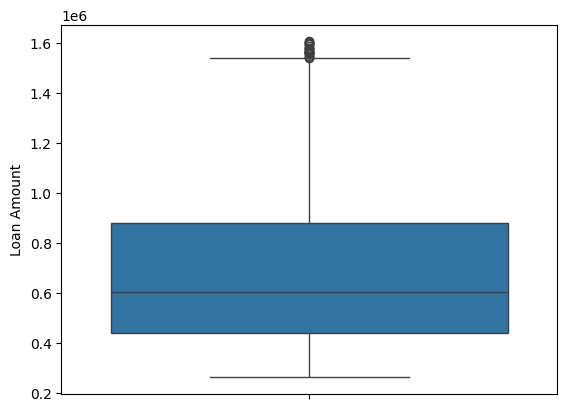

In [83]:
#checking for outliers and possible errors
sns.boxplot(data = applications['Loan Amount'])

<Axes: xlabel='Loan Amount', ylabel='Count'>

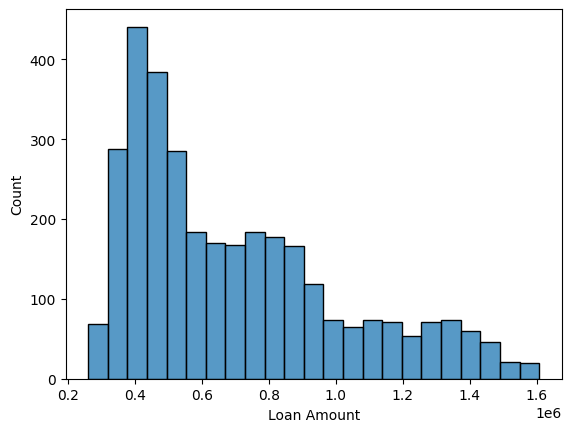

In [84]:
sns.histplot(data = applications['Loan Amount'])

In [107]:
total_revenue_from_applications = round(applications['Loan Amount'].sum()*0.04,2)
print('Total revenue from applications: $', total_revenue_from_applications)

Total revenue from applications: $ 91076973.44


In [118]:
#calculating revenue by year
yearly_revenue = {}
for year in [2020,2021,2022]:
    yearly_applications = applications[(applications['Application Date']<=pd.to_datetime(f'{year}/12/31'))*(applications['Application Date']>pd.to_datetime(f'{year-1}/12/31'))]
    yearly_revenue[year] = round(sum(yearly_applications['Loan Amount']*0.04),2)
    print('Application commission in year',year,' was $',yearly_revenue[year])
print('in total: $', sum(list(yearly_revenue.values())))

Application commission in year 2020  was $ 15026363.18
Application commission in year 2021  was $ 50552646.12
Application commission in year 2022  was $ 25497964.14
in total: $ 91076973.44


### Measuring loss from clawbacks
getting applications clawbacked, i.e closed within 1 year

In [59]:
clawbacks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Account ID          376 non-null    int64         
 1   Account Open Date   376 non-null    datetime64[ns]
 2   Account Close Date  376 non-null    datetime64[ns]
 3   Close Reason        376 non-null    object        
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 11.9+ KB


In [61]:
clawbacks

,Account ID,Account Open Date,Account Close Date,Close Reason
0,10040,2020-07-09,2021-01-29,REFINANCE
1,10230,2020-09-20,2020-12-10,REFINANCE
2,10393,2020-12-10,2021-04-16,DEFAULT
3,10331,2020-11-16,2021-05-20,REFINANCE
4,10326,2020-11-07,2021-03-15,DEFAULT
...,...,...,...,...
371,11923,2022-01-08,2022-04-30,REFINANCE
372,11961,2022-01-18,2022-04-20,REFINANCE
373,12343,2022-04-08,2022-05-20,REFINANCE
374,12334,2022-04-12,2022-06-04,DEFAULT


In [75]:
clawbacks['open date + 12 mths'] = clawbacks['Account Open Date']+ pd.DateOffset(months=12)
clawbacks

,Account ID,Account Open Date,Account Close Date,Close Reason,open date + 12 mths
0,10040,2020-07-09,2021-01-29,REFINANCE,2021-07-09
1,10230,2020-09-20,2020-12-10,REFINANCE,2021-09-20
2,10393,2020-12-10,2021-04-16,DEFAULT,2021-12-10
3,10331,2020-11-16,2021-05-20,REFINANCE,2021-11-16
4,10326,2020-11-07,2021-03-15,DEFAULT,2021-11-07
...,...,...,...,...,...
371,11923,2022-01-08,2022-04-30,REFINANCE,2023-01-08
372,11961,2022-01-18,2022-04-20,REFINANCE,2023-01-18
373,12343,2022-04-08,2022-05-20,REFINANCE,2023-04-08
374,12334,2022-04-12,2022-06-04,DEFAULT,2023-04-12


In [80]:
sum(clawbacks['Account Close Date']<clawbacks['open date + 12 mths'])

376

All are closed within 12 mths

In [48]:
clawbacked_bool_array = applications["Account ID"].isin(clawbacks["Account ID"])
clawbacked_applications = applications[clawbacked_bool_array]
len(clawbacked_applications)

376

In [53]:
total_loss_from_clawbacks = round(clawbacked_applications['Loan Amount'].apply(func= lambda x: x * 0.04).sum(),2)
print('Total loss from clawbacked: $', total_loss_from_clawbacks)

Total loss from clawbacked: $ 10827669.69


In [122]:
#finding yearly clawbacked loss
yearly_clawbacked_losses = {}
for year in [2020,2021,2022]:
    yearly_clawbacks = clawbacks[(clawbacks['Account Close Date']<= pd.to_datetime(f'{year}/12/31'))*(clawbacks['Account Close Date']> pd.to_datetime(f'{year-1}/12/31'))]
    yearly_clawbacked_bool_array= applications["Account ID"].isin(yearly_clawbacks["Account ID"])
    yearly_clawbacked_applications = applications[yearly_clawbacked_bool_array]
    yearly_loss_from_clawbacks = round(yearly_clawbacked_applications['Loan Amount'].apply(func= lambda x: x * 0.04).sum(),2)
    yearly_clawbacked_losses[year] = yearly_loss_from_clawbacks
    print('Yearly loss from clawbacked: $', yearly_loss_from_clawbacks)
print('in total: $', sum(list(yearly_clawbacked_losses.values())))

Yearly loss from clawbacked: $ 696265.26
Yearly loss from clawbacked: $ 6074415.93
Yearly loss from clawbacked: $ 4056988.5
in total: $ 10827669.69


### Revenue - clawback loss:

In [56]:
print('Revenue - clawback loss: $',total_revenue_from_applications-total_loss_from_clawbacks)

Revenue - clawback loss: $ 80249303.75


In [123]:
#yearly revenue - clawback loss
for year in [2020,2021,2022]:
    print(f'revenue - loss for year {year}: $', yearly_revenue[year]-yearly_clawbacked_losses[year])


revenue - loss for year 2020: $ 14330097.92
revenue - loss for year 2021: $ 44478230.19
revenue - loss for year 2022: $ 21440975.64


In [57]:
clawbacked_applications

,Application ID,Application Date,Customer ID,Loan Amount,Home Value,Annual Income,Interest Rate (p.a.),Term (months),Account ID
894,12945,2021-12-28,42798,858249.00,1042587.0,147648,0.0430,30,12343
965,12933,2021-12-16,41928,625570.00,822030.0,181213,0.0403,30,12334
1013,12820,2021-12-11,42173,446745.00,750984.0,217661,0.0425,15,12236
1021,12844,2021-12-09,41882,447925.00,553500.0,155796,0.0463,15,12257
1025,12833,2021-12-08,41918,1067268.00,1871842.0,177136,0.0349,15,12246
...,...,...,...,...,...,...,...,...,...
3246,10004,2020-06-21,35014,755609.24,869432.0,147527,0.0418,30,10003
3250,10009,2020-06-19,35191,815792.00,1507232.0,168068,0.0354,25,10007
3252,10008,2020-06-16,35258,950604.32,1173636.8,84912,0.0368,30,10006
3257,10010,2020-06-14,35152,1048110.00,1382829.0,122408,0.0394,30,10008
